In [1]:
# Code to compute the N0 bias term in the reconstructed lensing convergence bispectrum]
# Depends on cmblensplus, camb
# Currently only equilateral case

import numpy as np
import tqdm
import healpy as hp
import scipy
import vegas
import sys, os
sys.path.append('/home/amb257/cmblensplus/wrap') #Edit to location of wrap directory in cmblensplus installation
sys.path.append('/home/amb257/cmblensplus/utils')

import matplotlib
import matplotlib.pyplot as plt

# from cmblensplus/wrap/
import basic
import curvedsky as cs

# from cmblensplus/utils/
import plottools as pl

import camb
from camb import model, initialpower
print('using camb %s installed at %s'%(camb.__version__, os.path.dirname(camb.__file__)))


using camb 1.3.2 installed at /home/amb257/.conda/envs/cmblensplus/lib/python3.9/site-packages/camb


In [2]:
Tcmb  = 2.726e6    # CMB temperature
Lmax  = 1500       # maximum multipole of output normalization
rlmin, rlmax = 2, 1500  # CMB multipole range for reconstruction
L = np.linspace(0,Lmax,Lmax+1)
Lfac = (L*(L+1.))**2/(2*np.pi)
nside = 4096

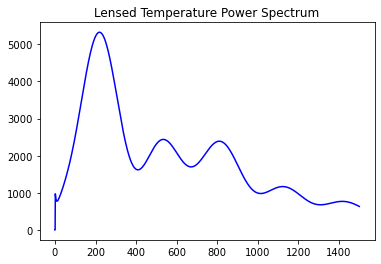

/tmp/ipykernel_16282/1496551720.py:24: RuntimeWarning: invalid value encountered in true_divide
  CTlens = DTlens * 2 * np.pi / (ls*(ls+1.))


In [3]:
# Get lensed power spectrum

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(1500, lens_potential_accuracy=0);
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, lmax = 1500, CMB_unit='muK')
DLlens = powers['total']
unlensedDL=powers['unlensed_scalar']
#We only want the temperature lensed power spectra so extract that:
DTlens = DLlens[:,0]
DTunlensed = unlensedDL[:,0]
ls = np.arange(DLlens.shape[0])

#Plot the CMB total lensed power spectrum to check as expected
plt.plot(ls, DTlens, color = 'blue')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Lensed Temperature Power Spectrum')
plt.show()

#Get Ct from Dt
CTlens = DTlens * 2 * np.pi / (ls*(ls+1.))
CTlens[0] = CTlens[1] = 0 #This to prevent nan numbers later in numerical calc when N0 += lcl*stuff and first element is nan. so (since nan + no. is still nan) just get N0 = nan.
#divide by mean temp squared to make dimensionless (camb has gien us cltt in units microkelvin)
lcl = CTlens / Tcmb**2
#Observed temp lensed power spectrum 
theta_fwhm = 1.4 #In arcminutes
sigma_noise = 10 #in muK-arcmin
arcmin2radfactor = np.pi / 60 / 180
noise_level = (sigma_noise*arcmin2radfactor/Tcmb)**2*np.exp(ls*(ls+1.)*(theta_fwhm*arcmin2radfactor)**2/np.log(2.)/8.)
ocl = np.copy(lcl) + noise_level

(1501,)


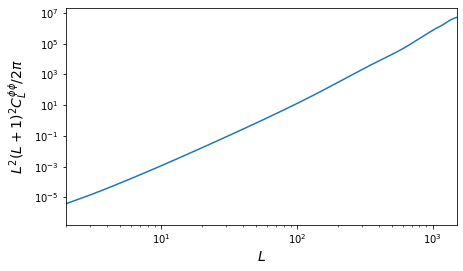

In [4]:
#Compute the gradient and curl normalisations FOR LENSING POTENTIAL (lfac='k' sets factors of L relevant for kappa)
Ag, Ac = {}, {}
Ag['TT'], Ac['TT'] = cs.norm_quad.qtt('lens',Lmax,rlmin,rlmax,lcl,ocl,lfac='k')

#We need the normalisation for the phi estimator for the analytic result (the A's in expression)
norm_phi, norm_curl_phi = {}, {}
norm_phi['TT'], norm_curl_phi['TT'] = cs.norm_quad.qtt('lens',Lmax,rlmin,rlmax,lcl,ocl,lfac='')
print(np.shape(norm_phi['TT']))
#Plot normalisation

pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=Lmax,xlog=True,ylog=True,ylab=r'$L^2(L+1)^2C^{\phi\phi}_L/2\pi$')
plt.plot(L,Lfac*Ag['TT'],label='TT')
plt.show()

In [5]:
# Now use vegas to do the numerical integration
# Note that all three of integrand, halfintegrand and secondhalfintegrand 
# Should reproduce the bias term.
# PROBLEM: Currently there's a difference between the terms

import vegas

###### Do some interpolation ###

def interpcl(l,l_camb,Cl):
    #Interpolates the power spectra (returns Cl at l)
    return np.interp(l,l_camb,Cl)

############ Define functions ##########

def dotprod(l1,l2):
    #Computes the dot product of two (multipole) vectors.
    l1dotl2 = l1[0]*l2[0] + l1[1]*l2[1]
    return l1dotl2

def vect_modulus(l1):
    #Computes the modulus of an input vector
    modl1 = np.sqrt(dotprod(l1,l1))
    return modl1

def response_func(ls, lcl, l1, l2, sizel1, sizel2):
    #Computes the response function f where <T(l1)T(l2)> = f(l1,l2)phi (T here is the lensed CMB temperature, phi is the lensing potential). Comes from taylor expanding the lensed temp.
    #CTlens is lensed power spectrum, l1, l2 are the multipole values.
    #L is the multipole at which we will evaluate the N(0) bias term
    L = l1 + l2
    lcl_sizel1 = interpcl(sizel1,ls, lcl)
    lcl_sizel2 = interpcl(sizel2, ls, lcl)
    f12 = dotprod(L,l1)*lcl_sizel1 + dotprod(L,l2)*lcl_sizel2
    return f12

def bigF(ls, l1, l2, sizel1, sizel2, lcl, ocl):
    #computes the function F(l1,l2) = f(l1,l2)/(2 Ctot(l1) Ctot(l2))
    # f12 is the response function
    ocl_sizel1 = interpcl(sizel1, ls, ocl)
    ocl_sizel2 = interpcl(sizel2, ls, ocl)
    bigF = response_func(ls,lcl, l1, l2, sizel1, sizel2) / ( 2 * ocl_sizel1 * ocl_sizel2)
    return bigF

def make_equilateral_L(sizeL):
    # Makes a set of 3 L's satisfying the triangle condition w/ L1 along the x axis and each L same length.
    L1, L2, L3 = np.zeros(2), np.zeros(2), np.zeros(2)
    L1[0] = sizeL
    
    L2[0] = -sizeL * np.cos(np.pi/3)
    L2[1] = sizeL * np.sin(np.pi/3)

    L3[0] = -sizeL * np.cos(np.pi/3)
    L3[1] = -sizeL * np.sin(np.pi/3)
    
    return L1, L2, L3

def integrand(ell):
    #Compute the integrand
    ellmin = 2
    ellmax = 1500
    
    ell_size = vect_modulus(ell)
    L1minusell = L1 - ell
    ellplusL2 = L2 + ell
    ellplusL3 = L3 + ell
    
    sizeL1 = vect_modulus(L1)
    sizeL2 = vect_modulus(L2)
    sizeL3 = vect_modulus(L3)
                                                            
    #The following can go out of bounds... in which case need the integrand to be zero.
    sizeL1minusell = vect_modulus(L1minusell)
    sizeellplusL2 = vect_modulus(ellplusL2) 
    sizeellplusL3 = vect_modulus(ellplusL3)
    
    if ell_size <= 1500 and  sizeL1minusell <= 1500 and  sizeellplusL2 <= 1500 and  sizeellplusL3  <= 1500 and ell_size >= 2 and  sizeL1minusell >= 2 and  sizeellplusL2 >= 2 and  sizeellplusL3  >= 2:
        ocl_ellsize = interpcl(ell_size,  ls, ocl)
        ocl_sizeL1minusell = interpcl(sizeL1minusell,  ls, ocl)
        ocl_sizeellplusL2 = interpcl(sizeellplusL2,  ls, ocl)
        ocl_sizeellplusL3 = interpcl(sizeellplusL3,  ls, ocl)
                                                                  
        Fint1int = bigF(ls, ell, L1-ell, ell_size, sizeL1minusell,lcl, ocl)
        Fint2int = bigF(ls, -ell,ellplusL2 , ell_size, sizeellplusL2, lcl, ocl)
        Fint12int = bigF(ls, L1minusell, ellplusL2, sizeL1minusell, sizeellplusL2, lcl, ocl)
        Fint3int = bigF(ls, ellplusL3, -ell, sizeellplusL3, ell_size, lcl, ocl)
        Fint13int = bigF(ls, -L1minusell, -ellplusL3, sizeL1minusell, sizeellplusL3, lcl, ocl)      
        integrand = 4 / ((2 * np.pi)**2) * Fint1int * ocl_ellsize * ocl_sizeL1minusell * (Fint2int * Fint12int * ocl_sizeellplusL2 + Fint3int * Fint13int * ocl_sizeellplusL3)
        return integrand
    else:
        return 0

    
def halfintegrand(ell):
    #Compute the integrand (first half of expression doubled - should be same as above)
    ellmin = 2
    ellmax = 1500

    ell_size = vect_modulus(ell)
    L1minusell = L1 - ell
    ellplusL2 = L2 + ell
    ellplusL3 = L3 + ell
    
    sizeL1 = vect_modulus(L1)
    sizeL2 = vect_modulus(L2)
    sizeL3 = vect_modulus(L3)
                                                            
    #The following can go out of bounds... in which case need the integrand to be zero.
    sizeL1minusell = vect_modulus(L1minusell)
    sizeellplusL2 = vect_modulus(ellplusL2) 
    sizeellplusL3 = vect_modulus(ellplusL3)
    
    if ell_size <= 1500 and  sizeL1minusell <= 1500 and  sizeellplusL2 <= 1500 and  ell_size >= 2 and  sizeL1minusell >= 2 and  sizeellplusL2 >= 2:
        ocl_ellsize = interpcl(ell_size,  ls, ocl)
        ocl_sizeL1minusell = interpcl(sizeL1minusell,  ls, ocl)
        ocl_sizeellplusL2 = interpcl(sizeellplusL2,  ls, ocl)
        ocl_sizeellplusL3 = interpcl(sizeellplusL3,  ls, ocl)
                                                                  
        Fint1int = bigF(ls, ell, L1-ell, ell_size, sizeL1minusell,lcl, ocl)
        Fint2int = bigF(ls, -ell,ellplusL2 , ell_size, sizeellplusL2, lcl, ocl)
        Fint12int = bigF(ls, L1minusell, ellplusL2, sizeL1minusell, sizeellplusL2, lcl, ocl)
        integrand = 8 / ((2 * np.pi)**2) * Fint1int * ocl_ellsize * ocl_sizeL1minusell * Fint2int * Fint12int * ocl_sizeellplusL2     
        return integrand
    else:
        return 0
    
def secondhalfintegrand(ell):
    #Compute the integrand (Now the second half of expression doubled, again should be equivalent)
    ellmin = 2
    ellmax = 1500

    ell_size = vect_modulus(ell)
    L1minusell = L1 - ell
    ellplusL2 = L2 + ell
    ellplusL3 = L3 + ell
    
    sizeL1 = vect_modulus(L1)
    sizeL2 = vect_modulus(L2)
    sizeL3 = vect_modulus(L3)
                                                            
    #The following can go out of bounds... in which case need the integrand to be zero.
    sizeL1minusell = vect_modulus(L1minusell)
    sizeellplusL2 = vect_modulus(ellplusL2)
    sizeellplusL3 = vect_modulus(ellplusL3)
    
    if ell_size <= 1500 and  sizeL1minusell <= 1500 and  sizeellplusL2 <= 1500 and  sizeellplusL3  <= 1500 and ell_size >= 2 and  sizeL1minusell >= 2 and  sizeellplusL2 >= 2 and  sizeellplusL3  >= 2:
        ocl_ellsize = interpcl(ell_size,  ls, ocl)
        ocl_sizeL1minusell = interpcl(sizeL1minusell,  ls, ocl)
        ocl_sizeellplusL2 = interpcl(sizeellplusL2,  ls, ocl)
        ocl_sizeellplusL3 = interpcl(sizeellplusL3,  ls, ocl)
                                                                  
        Fint1int = bigF(ls, ell, L1-ell, ell_size, sizeL1minusell,lcl, ocl)
        Fint3int = bigF(ls, ellplusL3, -ell, sizeellplusL3, ell_size, lcl, ocl)
        Fint13int = bigF(ls, -L1minusell, -ellplusL3, sizeL1minusell, sizeellplusL3, lcl, ocl)      
        integrand = 8 / ((2 * np.pi)**2) * Fint1int * ocl_ellsize * ocl_sizeL1minusell * Fint3int * Fint13int * ocl_sizeellplusL3 
        return integrand
    else:
        return 0

    
# Set up values of L at which want to calculate N0 (L is the side length of the triangle)
size_L_range = np.arange(200,1500,50)
N0bias = np.zeros(np.shape(size_L_range)[0])
integ = vegas.Integrator([[2, 1500],[2, 1500]])

for index, item in enumerate(size_L_range):
    L1,L2,L3 = make_equilateral_L(item)
    result = integ(integrand, nitn=6, neval=1000)
    N0bias[index] = result.mean
    print(item, N0bias[index])

N0biashalf = np.zeros(np.shape(size_L_range)[0])

for index, item in enumerate(size_L_range):
    L1,L2,L3 = make_equilateral_L(item)
    result = integ(halfintegrand, nitn=6, neval=1000)
    N0biashalf[index] = result.mean
    print(item, N0biashalf[index])

N0biassecondhalf = np.zeros(np.shape(size_L_range)[0])

for index, item in enumerate(size_L_range):
    L1,L2,L3 = make_equilateral_L(item)
    result = integ(secondhalfintegrand, nitn=6, neval=1000)
    N0biassecondhalf[index] = result.mean
    print(item, N0biassecondhalf[index])
                                         

200 5.504329548475404e+18
250 1.6880297654837805e+19
300 4.257004805571637e+19
350 8.866821140857695e+19
400 1.638513344938208e+20
450 2.963861129847501e+20
500 5.2723061020458693e+20
550 8.699446866827942e+20
600 1.305026425913982e+21
650 1.8109576215267398e+21
700 2.4067645302213753e+21
750 2.9618421439803965e+21
800 3.9175480411072543e+21
850 5.367056938054755e+21
900 7.287971501181835e+21
950 9.317503976697561e+21
1000 1.1620289152274502e+22
1050 1.4955825144884948e+22
1100 1.9885416799896464e+22
1150 2.615568259489109e+22
1200 3.243098491394878e+22
1250 3.827769580639032e+22
1300 4.424220429497819e+22
1350 5.21933306216755e+22
1400 6.250725819688649e+22
1450 7.009918511204266e+22
200 4.2589112691383987e+18
250 1.9383841759040877e+19
300 4.889217779798017e+19
350 1.0471445421477005e+20
400 2.093179202431222e+20
450 3.992410629048441e+20
500 7.310908903693183e+20
550 1.2648825337753785e+21
600 1.957810961222569e+21
650 2.719656488734957e+21
700 3.546392877210686e+21
750 4.4032369479

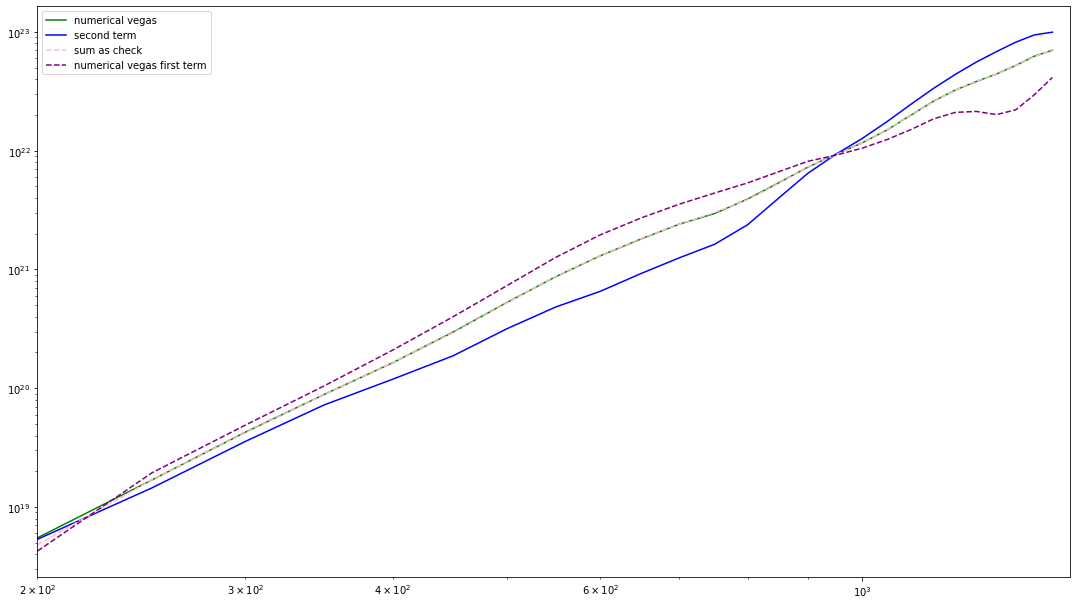

<Figure size 504x288 with 0 Axes>

In [9]:
L_fac_for_numerical = (size_L_range * (size_L_range + 1))**2 / (2 * np.pi)
plt.plot(size_L_range, N0bias, 'green',linestyle = '-', label = 'numerical vegas')
plt.plot(size_L_range, N0biassecondhalf, 'blue', label = 'second term')
plt.plot(size_L_range, 0.5*(N0biashalf+N0biassecondhalf), 'pink', linestyle = '--', label = 'sum as check')
plt.plot(size_L_range, N0biashalf, 'purple',linestyle = '--', label = 'numerical vegas first term')

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xlim(200, 1500)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig('myvegasequilateral.pdf')
plt.show()
plt.clf()

#### Note discrepancy betweeen terms

In [10]:
#### Now test the symmetry of the integrand
#### For a given L1, the first term in the integral should be equivalent to the second term with l -> L1-l

#### Test this for a specific bispec configuration:
L2, L3 = np.array((0,0)), np.array((0,0))
L1 = np.array((800,0)) #along the x axis
L3[0] = -800 * np.cos(np.pi/3)
L3[1] = 800 * np.sin(np.pi/3)
L2[0] = -800 * np.cos(np.pi/3)
L2[1] = -800 * np.sin(np.pi/3)

#### Now check integrand at a couple of ell values:

ell = np.array((200,100))
test3 = halfintegrand(ell)
test4 = secondhalfintegrand(L1 - ell)
print(test3, test4)

ell2 = np.array((550, 329))
test5 = halfintegrand(ell2)
test6 = secondhalfintegrand(L1 - ell2)
print(test5, test6)

#### These the same - integrand respects symmetry.

1.062059252605253e+16 1.062059252605253e+16
5619958010196847.0 5619958010196847.0


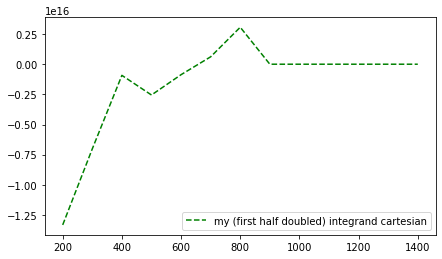

In [15]:
#### The following cells are extracted from a test comparing the functions F, f with external code

testtheta = 0.25*np.pi
l1 = np.linspace(rlmin, rlmax, int(rlmax-rlmin+1))
triangle_size = 1000
sizeells = np.arange(200, 1500, 100)
length = np.shape(sizeells)[0]
ell = np.zeros((length,2))
testing_mine = np.zeros(length)
testing_theirs = np.zeros(length)

# Make the ell vectors for a given polar angle testtheta
for index, item in enumerate(sizeells):
    ell[index,0] = item * np.cos(testtheta)
    ell[index,1] = item * np.sin(testtheta)

# Testing the integrand for a specific bispec configuration defined below:
L2, L3 = np.array((0,0)), np.array((0,0))
L1 = np.array((triangle_size,0)) #along the x axis
L2[0] = -triangle_size * np.cos(np.pi/3)
L2[1] = triangle_size * np.sin(np.pi/3)
L3[0] = -triangle_size * np.cos(np.pi/3)
L3[1] = -triangle_size * np.sin(np.pi/3)

# Find the integrand at every ell for this configuration
for index, item in enumerate(sizeells):
    testing_mine[index] = halfintegrand(ell[index, :])

#### now repeat for external code
#### Stuff

# Make plots
plt.plot(sizeells, testing_mine, 'green', linestyle = '--', label = 'my (first half doubled) integrand cartesian')
plt.legend()


#### SOME COMMENTS: Agreement of integrands at testtheeta = 0, disagreement off axis.

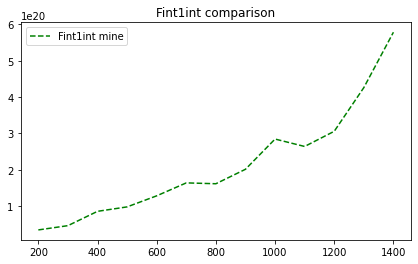

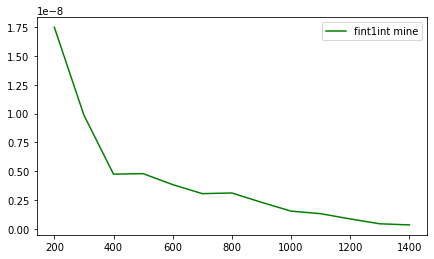

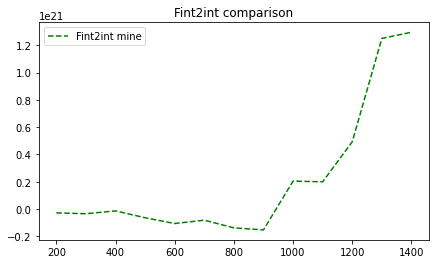

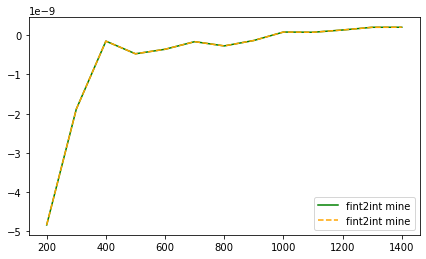

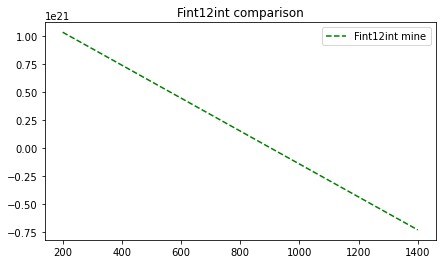

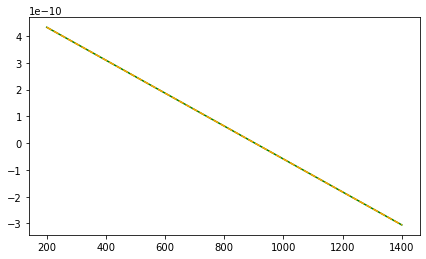

In [18]:
######## COMPARE F FUNCTIONS #################
##### COMPARING FINT1INT ##########

F1_mine = np.zeros(length)
f1_mine = np.copy(F1_mine)

###### As example of comparison:
#for index, item in enumerate(sizeells):
#    F1_theirs[index] = F1_XY(triangle_size, item, testtheta, ls, lcl, ocl)
#    f1_theirs[index] = f1_XY(triangle_size, item, testtheta, ls, lcl)
    
for index, item in enumerate(sizeells):
    sizeL1minusell = vect_modulus(L1-ell[index,:])
    F1_mine[index] = bigF(ls, ell[index,:], L1-ell[index,:], item, sizeL1minusell,lcl, ocl)
    f1_mine[index] = response_func(ls, lcl, ell[index,:], L1-ell[index,:], item, sizeL1minusell)

plt.plot(sizeells, F1_mine, 'green', linestyle = '--', label = 'Fint1int mine')
plt.legend()
plt.title('Fint1int comparison')
plt.show()

plt.plot(sizeells, f1_mine, 'green', linestyle = '-', label = 'fint1int mine')
plt.legend()
plt.show()

##### COMPARING FINT2INT ##########

F2_mine = np.copy(F1_mine)
f2_mine = np.copy(F1_mine)
f2check = np.copy(F1_mine)
    
for index, item in enumerate(sizeells):
    sizeellplusL2 = vect_modulus(ell[index,:] + L2)
    F2_mine[index] = bigF(ls, -ell[index,:], L2 + ell[index,:] , item, sizeellplusL2, lcl, ocl)
    f2_mine[index] = response_func(ls, lcl, -ell[index,:], L2 + ell[index,:], item, sizeellplusL2)
    
    #### Now directly compute f2 piece by piece as check:
    dp1 = dotprod(L2, -ell[index,:])
    dp1check = -1*(L2[0]*ell[index, 0] + L2[1]*ell[index, 1])
    #print(dp1, dp1check, 'dotprod1 check')
    dp2 = dotprod(L2, L2 + ell[index, :])
    Cell = interpcl(item, ls, lcl)
    #print(Cell, lcl[item], 'lcl test')
    CL2plusell = interpcl(sizeellplusL2, ls, lcl)
    f2check[index] = dp1*Cell + dp2*CL2plusell

plt.plot(sizeells, F2_mine, 'green', linestyle = '--', label = 'Fint2int mine')
plt.legend()
plt.title('Fint2int comparison')
plt.show()

plt.plot(sizeells, f2_mine, 'green', linestyle = '-', label = 'fint2int mine')
plt.plot(sizeells, f2check, 'orange', linestyle = '--', label = 'fint2int mine')
plt.legend()
plt.show()

##### COMPARING FINT12INT ##########

F12_mine = np.copy(F1_mine)
f12_mine = np.copy(F1_mine)
fint12intcheck = np.copy(F1_mine)

for index, item in enumerate(sizeells):
    F12_mine[index] = bigF(ls, L1-ell[index,:], L2 + ell[index,:], sizeL1minusell, sizeellplusL2, lcl, ocl)
    f12_mine[index] = response_func(ls, lcl, L1-ell[index,:], L2 + ell[index,:], sizeL1minusell, sizeellplusL2)

######Directly computing this term 

for index, item in enumerate(sizeells):
    #print(L1 - ell[index, :], 'L1-l')
    #print(L2 + ell[index, :], 'L2+l') 
    diff = dotprod(ell[index,:], L1+L2)
    alpha = triangle_size**2 + dotprod(L1, L2)
    #print(diff, 'ldot(L1+L2)')
    #print(alpha - diff, alpha + diff, 'two dot product terms'  ) #seem pretty different...
    dp1 = dotprod(L1 + L2, L1 - ell[index, :])
    dp2 = dotprod(L1 + L2, L2 + ell[index, :])
    #print(dp1, dp2, 'test dot prod terms') #This is working
    C1 = interpcl(sizeL1minusell, ls, lcl)
    C2 = interpcl(sizeellplusL2, ls, lcl)
    #print(sizeL1minusell, sizeellplusL2, 'sizes of the two arguments')
    #print(C1, C2, 'C comparison')
    term1 = dp1*C1
    term2 = dp2*C2
    #print(term1, term2 , 'the two terms')
    #print(term1+term2)
    fint12intcheck[index] = dp1 * C1 + dp2 * C2

plt.plot(sizeells, F12_mine, 'green', linestyle = '--', label = 'Fint12int mine')
plt.legend()
plt.title('Fint12int comparison')
plt.show()

plt.plot(sizeells, f12_mine, 'green', linestyle = '-', label = 'fint2int mine')
plt.plot(sizeells, fint12intcheck, 'orange', linestyle = '--', label = 'fint2int theirs')
plt.show()

##### SOME COMMENTS: Get good agreement for Fint1int